In [1]:
%matplotlib inline

# Precipitation frequency plots

In [2]:
import numpy as np
import xarray as xr
import xarray.ufuncs as xu   # for applying element-wise square root and square functions to dataset
import pandas as pd          # for working with date-time indexing
import cartopy.crs as ccrs   # map plots
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable  # to make reasonably-sized colorbars
import matplotlib.gridspec as gridspec
import glob

In [4]:
sim_dir = '/project/projectdirs/m2861/crjones/e3sm_runs/ne30_sp1_sgs_fix_72L_64x1_1km/hist/'

# ds0 = xr.open_mfdataset(sim_dir + "*.cam.h0*.nc")
ds1 = xr.open_mfdataset(sim_dir + "*.cam.h1*.nc")
ds2 = xr.open_mfdataset(sim_dir + "*.cam.h2*.nc")

In [88]:
ds2r = xr.open_dataset(sim_dir + "remap/ne30_sp1.cam.h2.1999-11_to_2000-02.remap.nc")
ds0r = xr.open_mfdataset(sim_dir + "remap/*cam.h0*.nc")

In [4]:
e3sm_ds = xr.open_mfdataset('/project/projectdirs/m2861/crjones/e3sm_runs/ne30_ZM_intel_72L_nc48/hist/*.h2*.nc')
# e3sm_ds

In [4]:
e3sm_ds = xr.open_dataset('/project/projectdirs/m2861/crjones/e3sm_runs/ne30_ZM_intel_72L_nc48/hist/prect_h2.gpcp.nc')

In [5]:
gpcp_ds = xr.open_mfdataset(['/project/projectdirs/m2861/crjones/daily/GPCP.daily.2000' + s + '.nc' for s in ('12','01','02')], concat_dim='time')
gpcp_ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 90)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Dimensions without coordinates: time
Data variables:
    precip   (time, lat, lon) float32 dask.array<shape=(90, 180, 360), chunksize=(31, 180, 360)>

In [66]:
e3sm_ds

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnd: 2, time: 540)
Coordinates:
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 1999-12-01 00:00:00 ... 2001-05-24 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds   (lat, nbnd) float64 ...
    lon_bnds   (lon, nbnd) float64 ...
    gw         (lat) float64 ...
    area       (lat, lon) float64 ...
    PRECT      (time, lat, lon) float32 ...
    time_bnds  (time, nbnd) float64 ...
Attributes:
    ne:                        30
    np:                        4
    Conventions:               CF-1.0
    source:                    CAM
    case:                      ne30_ZM_intel_72L_nc48
    title:                     UNSET
    logname:                   crjones
    host:                      titan-ext2
    Version:                   $Name$
    revision_Id:               $Id$
   

## prepare GPCP daily obs

In [6]:
mask = ~np.isnan(gpcp_ds.precip)

In [7]:
# weights 
gpcw = gpcp_ds.precip * (np.cos(gpcp_ds.lat / 180 * np.pi) / np.sum(np.cos(gpcp_ds.lat / 180 * np.pi) * len(gpcp_ds.lon)))

In [8]:
gprec = gpcp_ds.precip.values[mask]
gwhts = gpcw.values[mask] / len(gpcp_ds.time)

## prepare SP (hourly) and E3SM (daily) precip

In [9]:
def area_weight_ds(ds):
    if 'time' in ds['area'].dims:
        return ds['area'].mean(dim='time') / ds['area'].mean(dim='time').sum()
    else:
        return ds['area'] / ds['area'].sum()        

def area_weighted_var(ds, var, weights=None, rescale = 86400 * 1000):
    if weights is None:
        weights = area_weight_ds(ds)
    return ds[var] * weights * rescale

def hist_weights(ds, var, weights=None):
    return area_weighted_var(ds, var, weights).values.flatten() / len(ds.time)

def freq_weights(da):
    try:
        return np.ones_like(da.values.flatten()) * 100. / da.values.size
    except:
        return np.zeros_like(da.flatten()) + 100. / da.size

def calc_area_weighted_mean(ds, var, weights=None, rescale = 86400 * 1000):
    return area_weighted_var(ds, var, weights=weights, rescale=rescale).mean(dim='time').sum()

def hist_line(hout, **kwargs):
    y = hout[0]
    x = 0.5*(hout[1][:-1] + hout[1][1:])
    plt.plot(x, y, **kwargs)

In [10]:
ds2_djf = ds2.sel(time=slice('1999-12-01','2000-03-01'))
e3sm_djf = e3sm_ds.sel(time=slice('1999-12-01', '2000-03-01'))

In [11]:
prect_daily = ds2_djf['PRECT'] * 86400 * 1000 # mm/day
e3sm_prec = e3sm_djf['PRECT'] * 86400 * 1000

In [12]:
ds2_daily = xr.open_dataset('/project/projectdirs/m2861/crjones/e3sm_runs/ne30_sp1_sgs_fix_72L_64x1_1km/hist/daily_h2.nc')

In [13]:
ds2_djf = ds2_daily.sel(time=slice('1999-12-01','2000-03-01'))
prect_daily = ds2_djf['PRECT'] * 86400 * 1000 # mm/day

In [47]:
ds2_djf['area'].dims

('ncol',)

In [14]:
ds2_daily_gpcp = xr.open_dataset('/project/projectdirs/m2861/crjones/e3sm_runs/ne30_sp1_sgs_fix_72L_64x1_1km/hist/daily_h2.gpcp.nc')

In [15]:
ds2_gpcp_djf = ds2_daily_gpcp.sel(time=slice('1999-12-01','2000-03-01'))
prect_gpcp = ds2_gpcp_djf['PRECT'] * 86400 * 1000 # mm/day

In [72]:
gprec.size

5831359

(array([8.35307516e-01, 6.83122065e-02, 3.51146277e-02, 2.05902261e-02,
        1.31605686e-02, 8.87083097e-03, 6.09737799e-03, 4.16558130e-03,
        2.80534949e-03, 1.85497069e-03, 1.22047022e-03, 7.92268149e-04,
        5.34523771e-04, 3.67667297e-04, 2.36308552e-04, 1.68056880e-04,
        1.01177101e-04, 7.01380244e-05, 5.60761222e-05, 3.84130012e-05,
        2.88097509e-05, 2.88097509e-05, 1.74916345e-05, 1.50908219e-05,
        1.20040629e-05, 9.43176368e-06, 6.00203143e-06, 6.17351804e-06,
        2.40081257e-06, 3.60121886e-06, 6.85946449e-07, 8.57433061e-07,
        1.20040629e-06, 0.00000000e+00, 6.85946449e-07, 3.42973225e-07,
        5.14459837e-07, 5.14459837e-07, 0.00000000e+00, 3.42973225e-07,
        3.42973225e-07, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.42973225e-07]),
 array([  0.       ,   3.5604486,   7.1208973,  10.681346 ,  14.241795 ,
         17.802242 , 

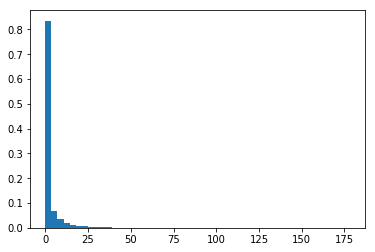

In [77]:
plt.hist(gprec,bins=50, weights=np.ones_like(gprec)/len(gprec))

## Frequency-weighted histograms

In [92]:
np.append(np.array([0]),np.logspace(np.log10(0.005), np.log10(400), 60))

array([0.00000000e+00, 5.00000000e-03, 6.05442947e-03, 7.33122325e-03,
       8.87727482e-03, 1.07493669e-02, 1.30162567e-02, 1.57612016e-02,
       1.90850167e-02, 2.31097776e-02, 2.79833037e-02, 3.38845877e-02,
       4.10303693e-02, 4.96830954e-02, 6.01605594e-02, 7.28475728e-02,
       8.82100983e-02, 1.06812364e-01, 1.29337585e-01, 1.56613057e-01,
       1.89640541e-01, 2.29633057e-01, 2.78059429e-01, 3.36698241e-01,
       4.07703150e-01, 4.93681994e-01, 5.97792562e-01, 7.23858581e-01,
       8.76510146e-01, 1.06135377e+00, 1.28517831e+00, 1.55620429e+00,
       1.88438582e+00, 2.28177621e+00, 2.76297063e+00, 3.34564216e+00,
       4.05119090e+00, 4.90552992e+00, 5.94003698e+00, 7.19270699e+00,
       8.70954744e+00, 1.05462681e+01, 1.27703273e+01, 1.54634092e+01,
       1.87244241e+01, 2.26731410e+01, 2.74545867e+01, 3.32443717e+01,
       4.02551408e+01, 4.87443822e+01, 5.90238848e+01, 7.14711895e+01,
       8.65434552e+01, 1.04794249e+02, 1.26893878e+02, 1.53654007e+02,
      

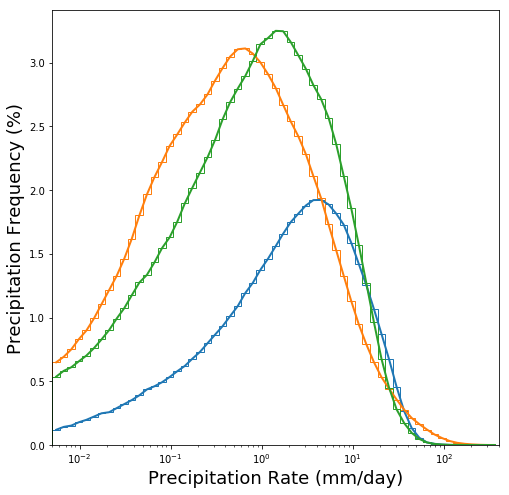

In [29]:
# GPCP first
plt.figure(figsize=(8,8))
log_bins = np.logspace(np.log10(0.005), np.log10(400), 60)
# log_bins = np.append(np.array([0]),np.logspace(np.log10(0.005), np.log10(400), 60))
gout = plt.hist(gprec, weights=np.ones_like(gprec)*100/len(gprec),
                bins=log_bins,
                histtype='step')
sout = prect_gpcp.plot.hist(weights=np.ones_like(prect_gpcp.values.flatten())*100/prect_gpcp.size, # weights=freq_weights(prect_gpcp),
                             bins=log_bins, histtype='step')
eout = e3sm_prec.plot.hist(weights=freq_weights(e3sm_prec),
                           bins=log_bins, histtype='step')
plt.gca().set_prop_cycle(None)
hist_line(gout, label='GPCP', linewidth=2)
hist_line(sout, label='SP-E3SM', linewidth=2)
hist_line(eout, label='E3SM', linewidth=2)
#plt.legend(fontsize=18)
plt.xscale('log')
plt.xlabel('Precipitation Rate (mm/day)', fontsize=18)
plt.ylabel('Precipitation Frequency (%)', fontsize=18)
#plt.title('DJF Precipitation Frequency Distribution', fontsize=18)
plt.title('')
plt.xlim((0.005, 400));
# plt.ylim((0,10))

In [33]:
(60/48)*36

45.0

In [84]:
np.sum(sout[0]), np.sum(gout[0])

(86.2403846153817, 43.158996041826306)

## Preciptation Amount Weighted Histograms

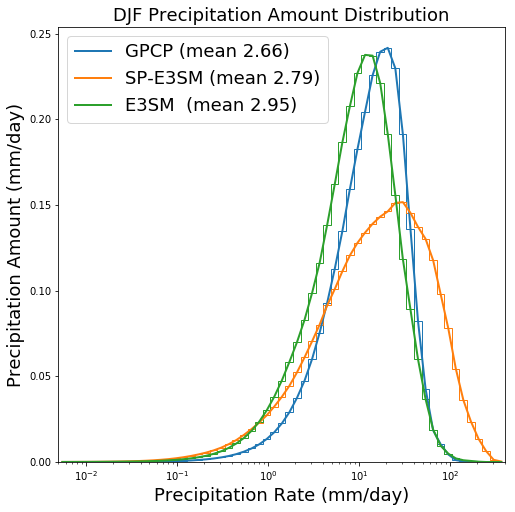

In [27]:
# GPCP first
fs = 18
plt.figure(figsize=(8,8))
log_bins = np.logspace(np.log10(0.005), np.log10(400), 60)
gout = plt.hist(gprec, weights=gwhts,
                bins=log_bins,
                histtype='step')
sout = prect_gpcp.plot.hist(weights=hist_weights(ds2_gpcp_djf, 'PRECT'),
                            bins=log_bins, histtype='step')
eout = e3sm_prec.plot.hist(weights=hist_weights(e3sm_djf, 'PRECT'),
                           bins=log_bins, histtype='step')
plt.gca().set_prop_cycle(None)
hist_line(gout, linewidth=2, label='GPCP' + ' (mean {:.2f})'.format(np.sum(gout[0])))
hist_line(sout, linewidth=2, label='SP-E3SM' + ' (mean {:.2f})'.format(calc_area_weighted_mean(ds2_gpcp_djf, 'PRECT').values))
hist_line(eout, linewidth=2, label='E3SM ' + ' (mean {:.2f})'.format(calc_area_weighted_mean(e3sm_djf, 'PRECT').values))
plt.legend(fontsize=fs)
plt.xscale('log')
plt.xlabel('Precipitation Rate (mm/day)', fontsize=fs)
plt.ylabel('Precipitation Amount (mm/day)', fontsize=fs)
plt.title('DJF Precipitation Amount Distribution', fontsize=fs)
plt.xlim((0.005, 400));

In [91]:
area_weights = ds2_djf['area'].mean(dim='time') / ds2_djf['area'].mean(dim='time').sum()

In [92]:
weights = (ds2_djf['PRECT'] * ds2_djf['area'].mean(dim='time') / ds2_djf['area'].mean(dim='time').sum()) * 86400 * 1000

In [93]:
mean_prect = ((ds2_djf['PRECT'].mean(dim='time') * 86400 * 1000) * area_weights).sum()
mean_prect.values

array(2.78757933)

In [94]:
prect_weights = ds2_djf['PRECT'] * 86400 * 1000 * area_weights

In [24]:
prect_daily = ds2_djf['PRECT'].resample(time='1D').mean(dim='time') * 86400 * 1000
weights = (ds2_djf['PRECT'] * ds2_djf['area'].mean(dim='time') / ds2_djf['area'].mean(dim='time').sum())
weights = weights.resample(time='1D').mean(dim='time')
weights

<xarray.DataArray (time: 92, ncol: 48602)>
dask.array<shape=(92, 48602), dtype=float64, chunksize=(1, 48602)>
Coordinates:
  * time     (time) datetime64[ns] 1999-12-01 1999-12-02 ... 2000-03-01
Dimensions without coordinates: ncol

In [19]:
weights

<xarray.DataArray (time: 2184, ncol: 48602)>
dask.array<shape=(2184, 48602), dtype=float64, chunksize=(120, 48602)>
Coordinates:
  * time     (time) object 1999-12-01 00:00:00 ... 2000-03-01 23:00:00
Dimensions without coordinates: ncol

In [1]:
prect_daily.plot.hist(weights=np.zeros_like(prect_daily.values.flatten()) + 1. / prect_daily.size, bins=np.logspace(np.log10(0.01), np.log10(400), 50))
plt.xscale('log')

NameError: name 'prect_daily' is not defined

Text(0, 0.5, 'Precipitation Amount (mm/day)')

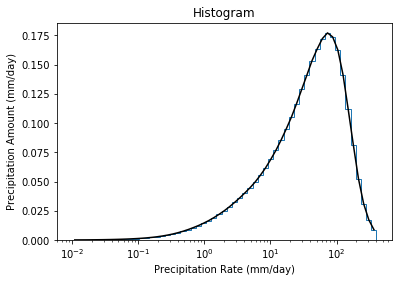

In [102]:
out = prect_daily.plot.hist(weights=prect_weights.values.flatten() / len(ds2_djf.time),
                            bins=np.logspace(np.log10(0.01), np.log10(400), 60),
                            histtype='step')
x = 0.5*(out[1][:-1] + out[1][1:])
y = out[0]
plt.plot(x, y, 'k-')
plt.xscale('log')
plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Precipitation Amount (mm/day)')

In [146]:
gprec = gpcp_ds.precip.values[mask]
gwhts = gpcw.values[mask] / len(gpcp_ds.time)
gprec.shape == gwhts.shape

True

In [130]:
np.count_nonzero(np.isnan(gpcp_ds.precip.values))

641

Text(0, 0.5, 'Precipitation Amount (mm/day)')

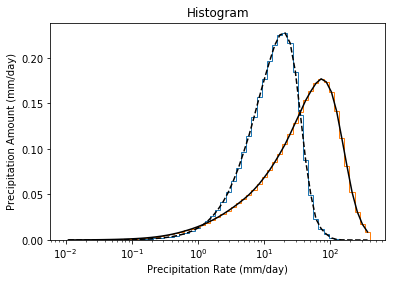

In [148]:
gy, gx, _ = plt.hist(gprec, weights=gwhts,
            bins=np.logspace(np.log10(0.01), np.log10(400), 60),
            histtype='step')
plt.plot(0.5*(gx[:-1] + gx[1:]), gy, 'k--')
out = prect_daily.plot.hist(weights=prect_weights.values.flatten() / len(ds2_djf.time),
                            bins=np.logspace(np.log10(0.01), np.log10(400), 60),
                            histtype='step')
x = 0.5*(out[1][:-1] + out[1][1:])
y = out[0]
plt.plot(x, y, 'k-')
plt.xscale('log')
plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Precipitation Amount (mm/day)')

Text(0, 0.5, 'Precipitation Amount (mm/day)')

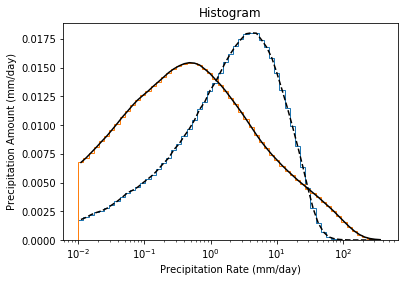

In [151]:
gy, gx, _ = plt.hist(gprec,
                     weights=np.zeros_like(gprec.flatten()) + 1. / gprec.size,
            bins=np.logspace(np.log10(0.01), np.log10(400), 60),
            histtype='step')
plt.plot(0.5*(gx[:-1] + gx[1:]), gy, 'k--')
out = prect_daily.plot.hist(weights=np.zeros_like(prect_daily.values.flatten()) + 1. / prect_daily.size,
                            bins=np.logspace(np.log10(0.01), np.log10(400), 60),
                            histtype='step')
x = 0.5*(out[1][:-1] + out[1][1:])
y = out[0]
plt.plot(x, y, 'k-')
plt.xscale('log')
plt.xlabel('Precipitation Rate (mm/day)')
plt.ylabel('Precipitation Amount (mm/day)')

In [95]:
b = np.logspace(np.log10(0.01), np.log10(400), 60)
b[1:]/b[:-1]

array([1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333, 1.19674333,
       1.19674333, 1.19674333, 1.19674333, 1.19674333])

In [82]:
out[0], out[1]

(array([1.21298995e-04, 1.74617217e-04, 2.51361872e-04, 3.58761657e-04,
        5.14250233e-04, 7.34140034e-04, 1.03312079e-03, 1.44289106e-03,
        1.97629436e-03, 2.71222879e-03, 3.72068589e-03, 5.09010436e-03,
        6.90664577e-03, 9.27453856e-03, 1.22705740e-02, 1.59107468e-02,
        2.01312101e-02, 2.51295560e-02, 3.10798042e-02, 3.79229925e-02,
        4.58963840e-02, 5.47927893e-02, 6.46128388e-02, 7.57691586e-02,
        8.91805928e-02, 1.05196969e-01, 1.23774420e-01, 1.45118535e-01,
        1.69503248e-01, 1.97201462e-01, 2.25474556e-01, 2.49368501e-01,
        2.65810504e-01, 2.59751411e-01, 2.24986213e-01, 1.60055895e-01,
        9.14098813e-02, 4.19794505e-02, 1.62206454e-02]),
 array([1.00000000e-02, 1.31220455e-02, 1.72188077e-02, 2.25945978e-02,
        2.96487339e-02, 3.89052035e-02, 5.10515849e-02, 6.69901218e-02,
        8.79047425e-02, 1.15349003e-01, 1.51361486e-01, 1.98617230e-01,
        2.60626432e-01, 3.41995189e-01, 4.48767642e-01, 5.88874941e-01,
      

In [78]:
sum(out[0])

2.7828592774431407

In [57]:
prect_daily.values.flatten()

array([0.18344982, 0.08905119, 0.02805553, ..., 1.70199128, 4.53848011,
       2.97325454])

In [16]:
plt.hist(weights=)

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'CFTimeIndex'

### resampling stuff
ignore for now

In [36]:
dt = ds2_djf.time
dt2 = xr.CFTimeIndex(dt).to_datetimeindex()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/coding/cftimeindex.py:434: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  'dates.'.format(calendar), RuntimeWarning)


In [21]:
ds2_djf['time'] = dt2

In [7]:
ds2_djf = ds2_djf.resample(time='1D').mean()
ds2_djf

<xarray.Dataset>
Dimensions:    (ilev: 73, lev: 72, nbnd: 2, ncol: 48602, time: 92)
Coordinates:
  * time       (time) datetime64[ns] 1999-12-01 1999-12-02 ... 2000-03-01
  * lev        (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * ilev       (ilev) float64 0.1 0.1477 0.218 0.3219 ... 990.5 997.0 1e+03
Dimensions without coordinates: nbnd, ncol
Data variables:
    lat        (time, ncol) float64 dask.array<shape=(92, 48602), chunksize=(1, 48602)>
    lon        (time, ncol) float64 dask.array<shape=(92, 48602), chunksize=(1, 48602)>
    area       (time, ncol) float64 dask.array<shape=(92, 48602), chunksize=(1, 48602)>
    hyam       (time, lev) float64 dask.array<shape=(92, 72), chunksize=(1, 72)>
    hybm       (time, lev) float64 dask.array<shape=(92, 72), chunksize=(1, 72)>
    P0         (time) float64 1e+05 1e+05 1e+05 1e+05 ... 1e+05 1e+05 nan 1e+05
    hyai       (time, ilev) float64 dask.array<shape=(92, 73), chunksize=(1, 73)>
    hybi       (time, ilev)